In [23]:

import sys
import os.path as path
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

import pickle
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg

In [24]:
# General method to extact the HOG of the image

def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualize=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualize=False, feature_vector=feature_vector_flag)
        return hog_features


In [25]:

def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

In [26]:

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList

In [27]:
%%time
#creating pascal file for the first time to minimize processing time
orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
clf_path = 'clf_pickle_all_v1.p' 

# if svm classifer exist, load it; otherwise, compute the svm classifier
if path.isfile(clf_path):
    print('loading existing classifier...')
    with open(clf_path, 'rb') as file:
        clf_pickle = pickle.load(file)
        vehicleFeatures = clf_pickle["vehicleFeatures"]
        nonVehicleFeatures = clf_pickle["nonVehicleFeatures"]

else:
    #reading image paths with glob
    vehicle_image_arr = glob.glob('C:/Phase2/vehicles/*/*.png')

    # read images and append to list
    vehicle_images_original=[]
    for imagePath in vehicle_image_arr:
        readImage=cv2.imread(imagePath)
        rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
        vehicle_images_original.append(rgbImage)

    print('Reading of Vehicle Images Done')

    non_vehicle_image_arr = glob.glob('C:/Phase2/non-vehicles/*/*.png')


    non_vehicle_images_original=[]
    for imagePath in non_vehicle_image_arr:
        readImage=cv2.imread(imagePath)
        rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
        non_vehicle_images_original.append(rgbImage)

    print("Reading of Non Vehicle Images Done")

    print("No. of Vehicle Images Loaded "+ str(len(vehicle_image_arr)))
    print("No. of Non-Vehicle Images Loaded "+ str(len(non_vehicle_images_original)))
    vehicleFeatures= ExtractFeatures(vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
    nonVehicleFeatures= ExtractFeatures(non_vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
    # save classifier
    clf_pickle = {}
    clf_pickle["vehicleFeatures"] = vehicleFeatures
    clf_pickle["nonVehicleFeatures"] = nonVehicleFeatures

    destnation = clf_path
    pickle.dump( clf_pickle, open( destnation, "wb" ) )
    print("Classifier is written into: {}".format(destnation))

loading existing classifier...
Wall time: 5.14 s


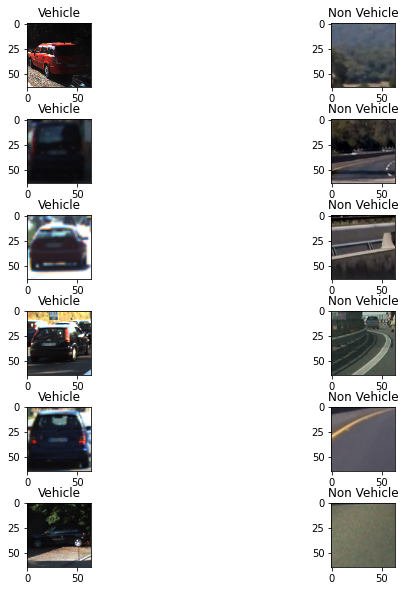

In [28]:
f, axes = plt.subplots(6,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
vehicle_image_arr = glob.glob('C:/Phase2/vehicles/*/*.png')
vehicle_images_original=[]
for imagePath in vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)
non_vehicle_images_original=[]
non_vehicle_image_arr = glob.glob('C:/Phase2/non-vehicles/*/*.png')
for imagePath in non_vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)
for index in range(6):
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")

Feature Vector Length Returned is  324
No of features that can be extracted from image  4096


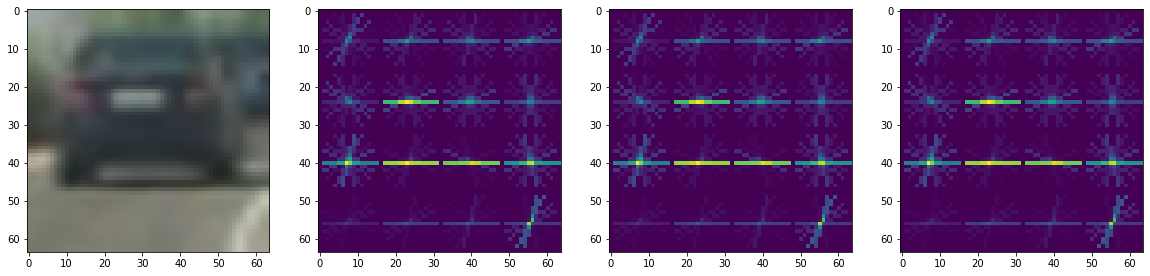

In [29]:
image=vehicle_images_original[1]
image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0=image[:,:,0]
image_channel_1=image[:,:,0]
image_channel_2=image[:,:,0]

feature_0,hog_img_0=GetFeaturesFromHog(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1=GetFeaturesFromHog(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2=GetFeaturesFromHog(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes= plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(vehicle_images_original[1])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)

print("Feature Vector Length Returned is ",len(feature_0))
print("No of features that can be extracted from image ",len(hog_img_0.ravel()))

In [30]:
featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])

In [31]:
# train test split of data

from sklearn.model_selection import train_test_split
#Split arrays or matrices into random train and test subsets.
X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)
#xtrain and xtest for features list
#ytrain and u test for label list

In [32]:

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()  #centering and scaling
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
#Input samples
#return transformed array
X_test_scaled= scaler.transform(X_test)

In [33]:
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)

LinearSVC()

In [34]:

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [35]:

def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

In [36]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap 

In [37]:

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [38]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [39]:

class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


In [40]:

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list
    

Total No of windows are  470


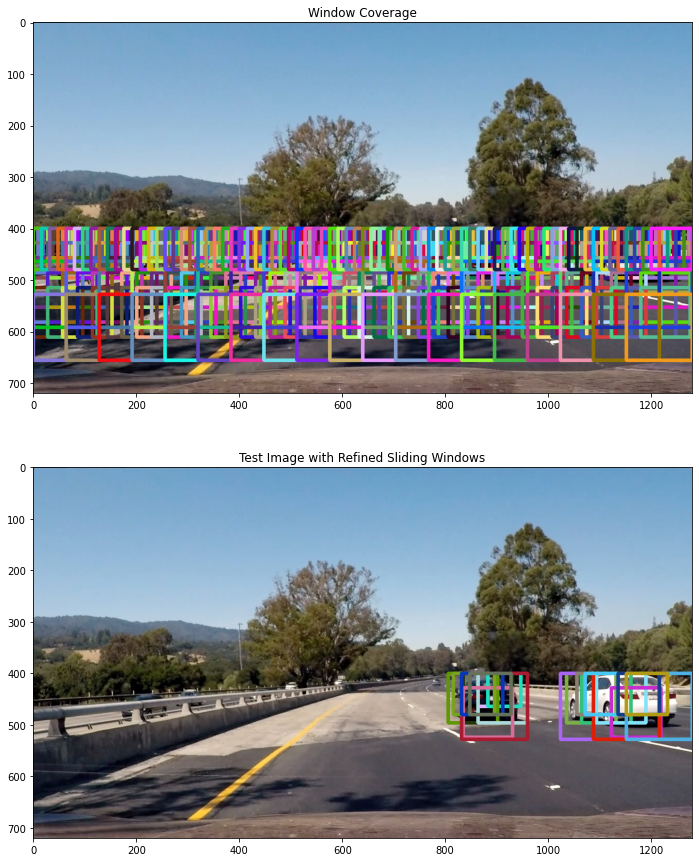

In [41]:

image = mpimg.imread('C:/Phase2/test_images/test4.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows=DrawCars(image,windows, True)



f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)


 Number of Cars found -  2


Text(0.5, 1.0, 'Final Image after applying Heat Map')

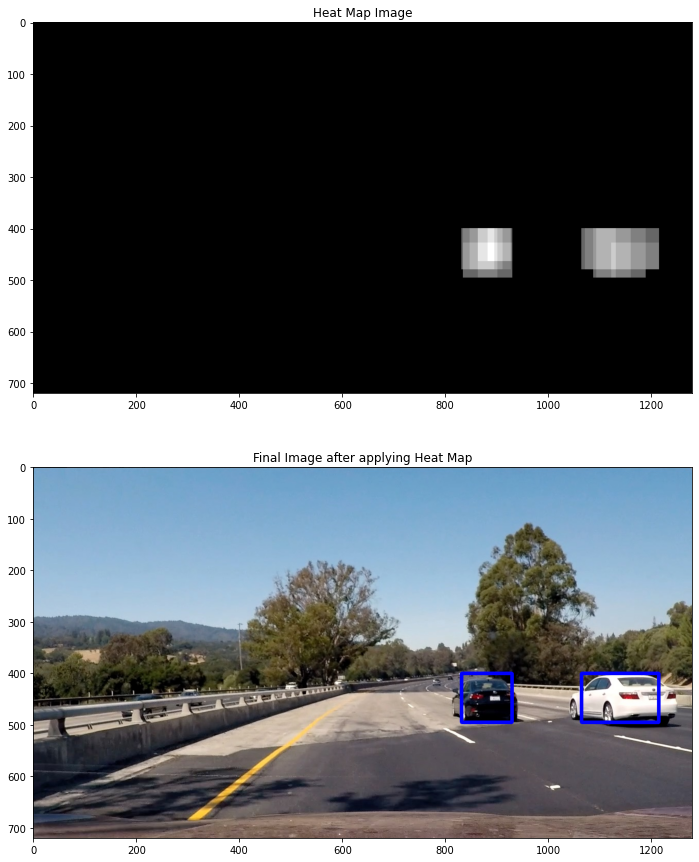

In [42]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heat

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

In [43]:


def Pipeline(image):

    rand= random.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=DrawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)

            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 21 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

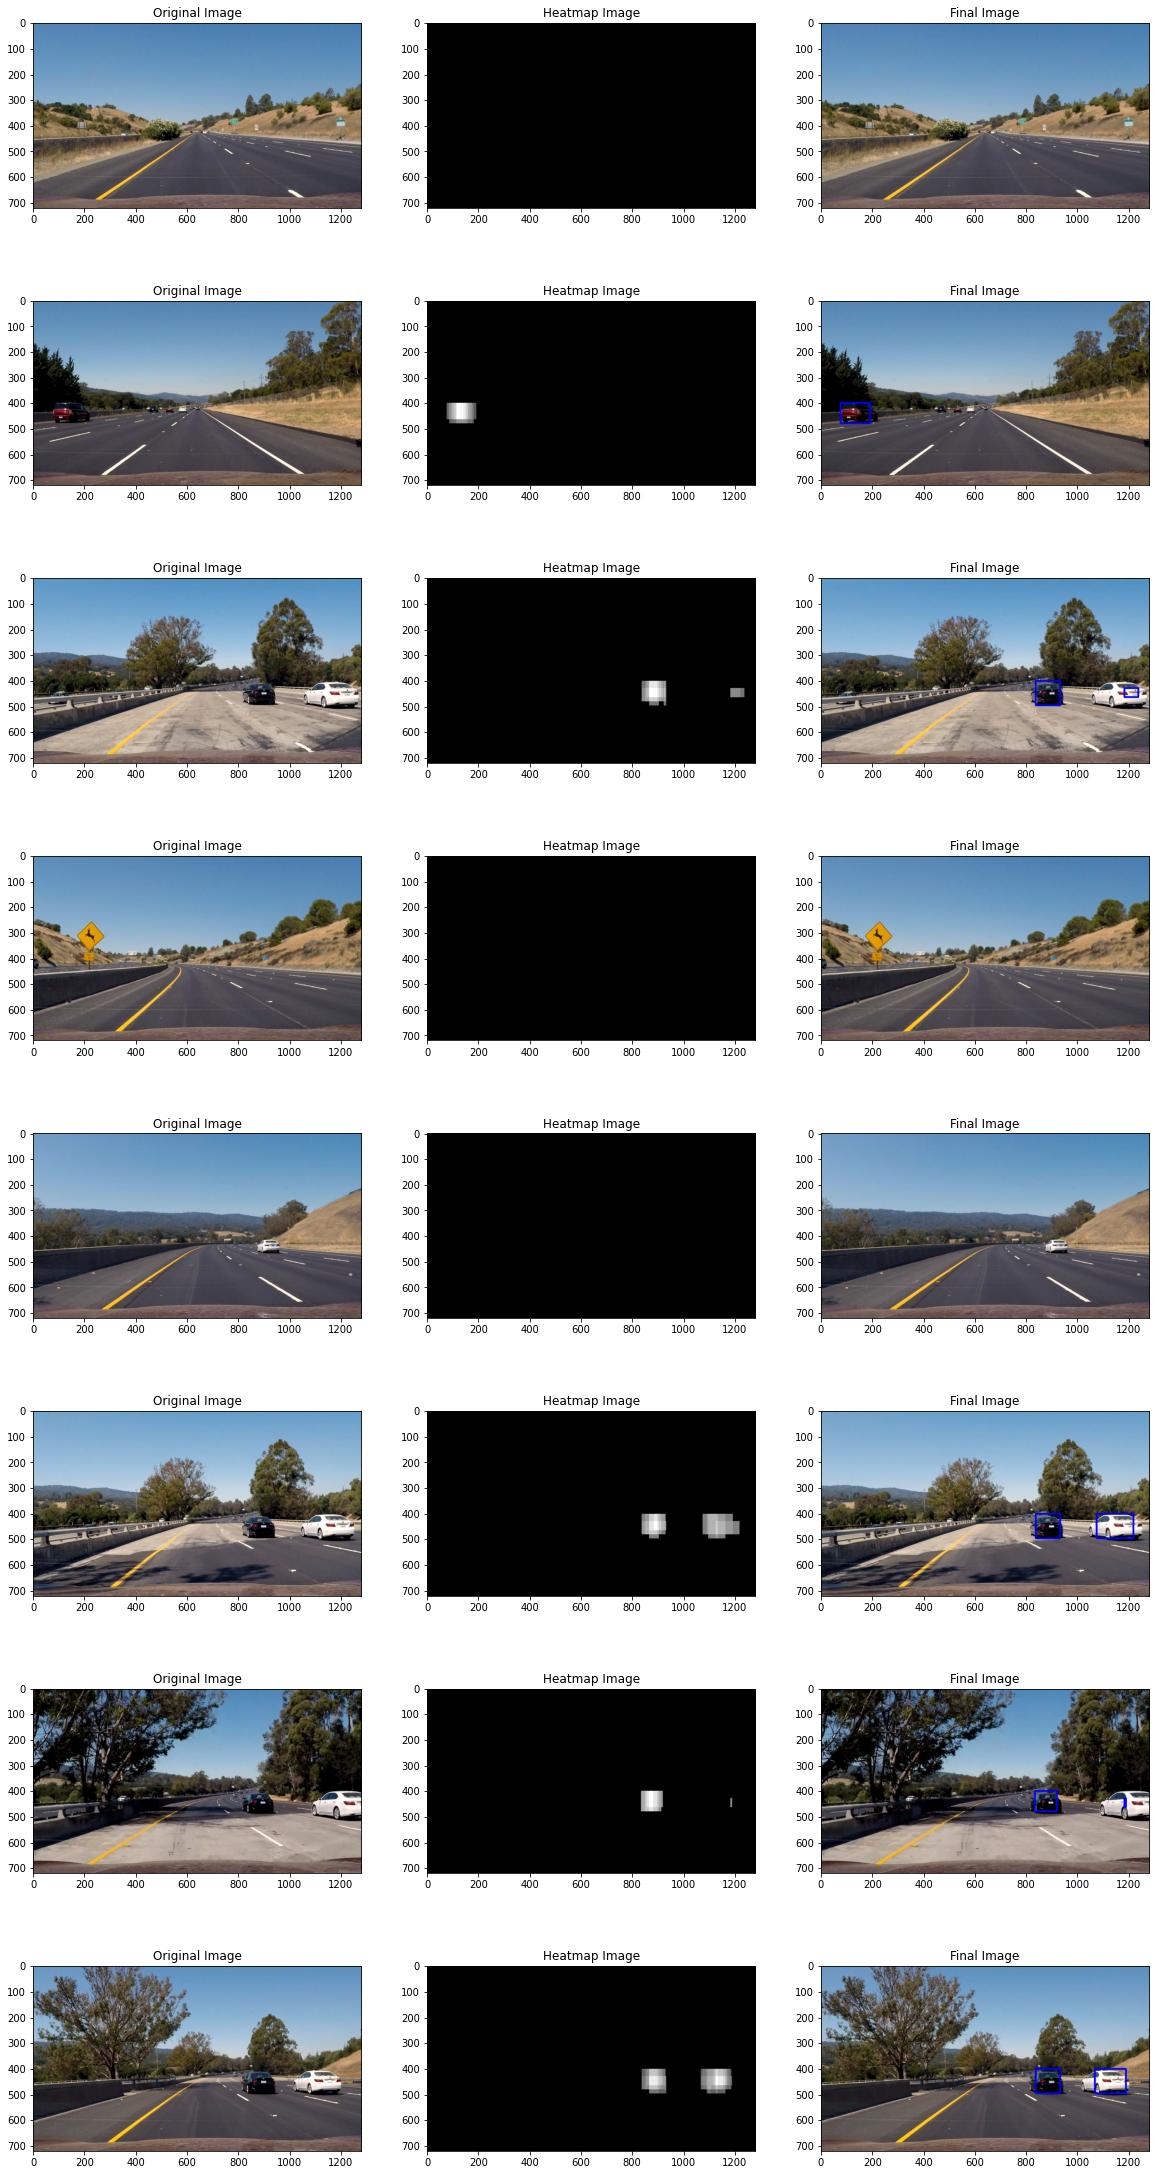

In [46]:
test_images= glob.glob("C:/Phase2/test_images/*.jpg")
f, axes= plt.subplots(8,3, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    refinedWindows=DrawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 4)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(draw_img)
    axes[index,2].set_title("Final Image")


In [45]:
#keepTrack = KeepTrack()
#import moviepy
#from moviepy.editor import VideoFileClip
#video_output1 = 'C:/Phase2/output_videos/output'.mp4'
#video_input1 = VideoFileClip('C:/Phase2/test_videos/project_video.mp4')
#processed_video = video_input1.fl_image(Pipeline)
#%time processed_video.write_videofile(video_output1, audio=False)
#video_input1.reader.close()
#video_input1.audio.reader.close_proc()